In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import xgboost
import matplotlib.pyplot as plt



data = pd.read_csv('data/predict_model_raw_data.csv')

data[['pos','neg','neu']] = data[['pos','neg','neu']].pct_change()

data['label'] = data['Close'].diff()
data = data[data['label'].notna()]
data['label'] = data['label'].map(lambda x: 1 if x > 0 else 0)
# lag
# data[['pos','neg','neu']] = data[['pos','neg','neu']].shift(5)

start = '2020-01-01'
end = '2023-05-31'
data['date'] = pd.to_datetime(data['date'])
data = data[(data['date']>= pd.Timestamp(start)) & (data['date'] <= pd.Timestamp(end))]




# 
# df = pd.read_csv('predict_model_train_data.csv')
df = data
# print(df)
features = df[['pos', 'neg', 'neu']]
labels = df['label']
# 假设数据集X为特征矩阵，y为目标变量
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


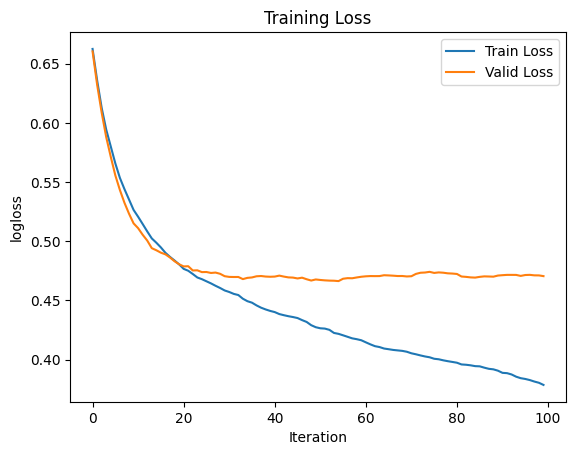

In [2]:
# 定义模型参数
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',  # 二分类任务
    'eval_metric': 'logloss',         # 评估指标为logloss，在训练过程中输出
    'eta': 0.1,                       # 学习率，控制每次迭代的步长，默认为0.3
    'max_depth': 3,                   # 决策树最大深度
    'min_child_weight': 1,            # 叶子节点的最小权重
    'gamma': 0.1,                     # 节点分裂时损失函数的下降阈值
    'subsample': 0.8,                 # 每棵树随机采样的比例
    'colsample_bytree': 0.8,          # 每棵树进行特征采样的比例
    'reg_alpha': 0.01,                # L1正则化系数
    'reg_lambda': 0.01,               # L2正则化系数
    'seed': 42                        # 随机种子，保证结果可复现
}

# params = {
#     'booster': 'gbtree',
#     'objective': 'binary:logistic',  # 二分类任务
#     'eval_metric': 'logloss',         # 评估指标为logloss，在训练过程中输出
# }
# 将数据转换为DMatrix格式，优化XGBoost性能
dtrain = xgboost.DMatrix(X_train, label=y_train)
dvalid = xgboost.DMatrix(X_test, label=y_test)



# 训练模型
evals_result = {}
model = xgboost.train(params=params, dtrain=dtrain, num_boost_round=100, evals=[(dtrain, 'train'), (dvalid, 'valid')],evals_result=evals_result,verbose_eval=False)
# 提取损失值
# print(evals_result['train'])
train_loss = evals_result['train']['logloss']
valid_loss = evals_result['valid']['logloss']
# 绘制损失曲线
# plt.figure(figsize=(10, 6))
plt.plot(range(len(train_loss)), train_loss, label='Train Loss')
plt.plot(range(len(valid_loss)), valid_loss, label='Valid Loss')
plt.xlabel('Iteration')
plt.ylabel('logloss')
plt.title('Training Loss')
plt.legend()
plt.show()

accuracy_score: 0.768
precision_score: 0.7751937984496124
recall_score: 0.7751937984496124
f1_score: 0.7751937984496124


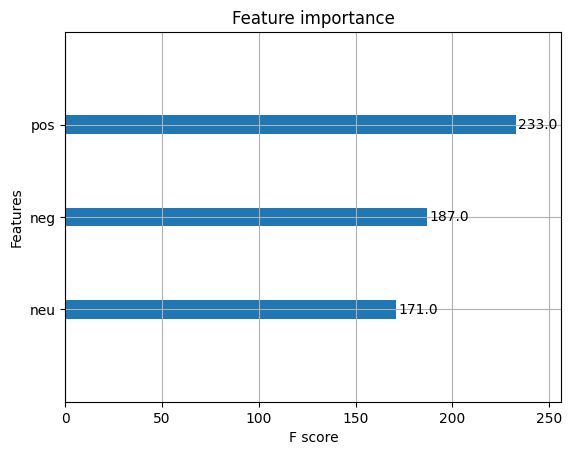

In [3]:
# 将测试集转换为DMatrix格式
dtest = xgboost.DMatrix(X_test)

# 在测试集上预测
y_pred = model.predict(dtest)

# 将预测结果转换为0-1二分类
y_pred_binary = [1 if i > 0.5 else 0 for i in y_pred]

# 计算准确率
print('accuracy_score:', accuracy_score(y_test, y_pred_binary))
print('precision_score:', precision_score(y_test, y_pred_binary))
print('recall_score:', recall_score(y_test, y_pred_binary))
print('f1_score:', f1_score(y_test, y_pred_binary))

from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model)
pyplot.show()


In [4]:
# # 通过遍历的方式，在不同的学习率的情况下，看哪个学习率的情况下，模型最优
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold

# # 设定要调节的 learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] 

# # 和原代码相比就是在 model 后面加上 grid search 这几行：
# model = xgboost.XGBClassifier()

# learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.6]
# subsample = [0.8, 0.9]
# colsample_bytree = [0.6, 0.8]
# max_depth = [3,5,8]

# parameters = { 
#     'eta': learning_rate,
#               'subsample': subsample,
#               'colsample_bytree':colsample_bytree,
#               'max_depth': max_depth
#               }


# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
# grid_search = GridSearchCV(model, parameters, scoring="f1", n_jobs=-1, cv=kfold)
# grid_result = grid_search.fit(features, labels)

# # 输出最佳学习率和其对应的分数
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# #Best: -0.483013 using {'learning_rate': 0.1}

# # 打印出每一个学习率对应的分数
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
